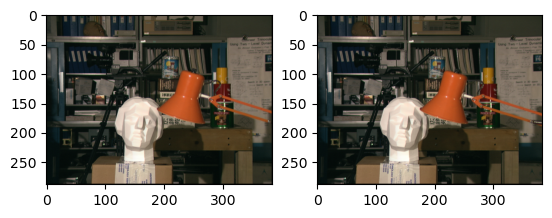

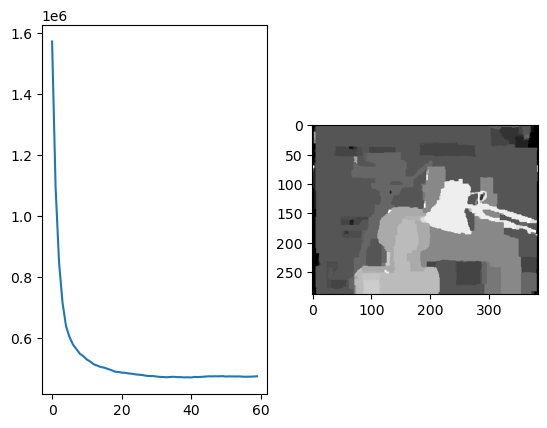

In [3]:
import numpy as np
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Parameters
num_disp_values=16 # these images have disparity between 0 and 15.
Lambda=10.0
nb_iterations=60

#计算数据代价
def compute_data_cost(I1, I2, num_disp_values, Tau):
    h,w,_ = I1.shape
    dataCost=np.zeros((h,w,num_disp_values))

    for lp in range(num_disp_values):
        dataCost[:, :, lp] = np.minimum(1./3*norm(I1 - np.roll(I2, lp, axis=1), axis=2, ord=1), Tau*np.ones((h, w)))

    return dataCost

#用于计算总能量，它接受数据代价dataCost、视差图disparity和Lambda作为输入，并返回一个标量值表示总能量。
def compute_energy(dataCost,disparity,Lambda):
    h,w,num_disp_values = dataCost.shape

    hh, ww = np.meshgrid(range(h), range(w), indexing='ij')
    dplp = dataCost[hh, ww, disparity]

    # Unitary cost of assigning this disparity to each pixel
    energy = np.sum(dplp)

    # Compute interaction cost of each neighbors
    interactionCostU = Lambda*(disparity - np.roll(disparity, 1, axis=0) != 0)
    interactionCostL = Lambda*(disparity - np.roll(disparity, 1, axis=1) != 0)
    interactionCostD = Lambda*(disparity - np.roll(disparity, -1, axis=0) != 0)
    interactionCostR = Lambda*(disparity - np.roll(disparity, -1, axis=1) != 0)

    # Ignoring edge costs
    interactionCostU[0, :] = 0
    interactionCostL[:, 0] = 0
    interactionCostD[-1, :] = 0
    interactionCostR[:, -1] = 0

    # Adding interaction cost of each neighbors
    energy += np.sum(interactionCostU)
    energy += np.sum(interactionCostL)
    energy += np.sum(interactionCostD)
    energy += np.sum(interactionCostR)

    return energy

#进行消息图更新
def update_msg(msgUPrev,msgDPrev,msgLPrev,msgRPrev,dataCost,Lambda):
    msgU=np.zeros(dataCost.shape)
    msgD=np.zeros(dataCost.shape)
    msgL=np.zeros(dataCost.shape)
    msgR=np.zeros(dataCost.shape)

    h,w,num_disp_values = dataCost.shape

    msg_incoming_from_U = np.roll(msgDPrev, 1, axis=0)
    msg_incoming_from_L = np.roll(msgRPrev, 1, axis=1)
    msg_incoming_from_D = np.roll(msgUPrev, -1, axis=0)
    msg_incoming_from_R = np.roll(msgLPrev, -1, axis=1)

    npqU = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_R
    npqL = dataCost + msg_incoming_from_U + msg_incoming_from_D + msg_incoming_from_R
    npqD = dataCost + msg_incoming_from_L + msg_incoming_from_U + msg_incoming_from_R
    npqR = dataCost + msg_incoming_from_L + msg_incoming_from_D + msg_incoming_from_U

    spqU = np.amin(npqU, axis=2)
    spqL = np.amin(npqL, axis=2)
    spqD = np.amin(npqD, axis=2)
    spqR = np.amin(npqR, axis=2)

    for lp in range(num_disp_values):
        msgU[:, :, lp] = np.minimum(npqU[:, :, lp], Lambda + spqU)
        msgL[:, :, lp] = np.minimum(npqL[:, :, lp], Lambda + spqL)
        msgD[:, :, lp] = np.minimum(npqD[:, :, lp], Lambda + spqD)
        msgR[:, :, lp] = np.minimum(npqR[:, :, lp], Lambda + spqR)
    return msgU,msgD,msgL,msgR

#对消息图进行归一化操作
def normalize_msg(msgU,msgD,msgL,msgR):
    avg=np.mean(msgU,axis=2)
    msgU -= avg[:,:,np.newaxis]
    avg=np.mean(msgD,axis=2)
    msgD -= avg[:,:,np.newaxis]
    avg=np.mean(msgL,axis=2)
    msgL -= avg[:,:,np.newaxis]
    avg=np.mean(msgR,axis=2)
    msgR -= avg[:,:,np.newaxis]

    return msgU,msgD,msgL,msgR

#计算置信度，接受数据代价dataCost和四个消息图msgU、msgD、msgL、msgR作为输入，并返回计算得到的置信度。
def compute_belief(dataCost,msgU,msgD,msgL,msgR):
    """Compute beliefs, sum of data cost and messages from all neighbors"""
    beliefs=dataCost.copy()

    msg_incoming_from_U = np.roll(msgD, 1, axis=0)
    msg_incoming_from_L = np.roll(msgR, 1, axis=1)
    msg_incoming_from_D = np.roll(msgU, -1, axis=0)
    msg_incoming_from_R = np.roll(msgL, -1, axis=1)

    beliefs += msg_incoming_from_D + msg_incoming_from_L + msg_incoming_from_R + msg_incoming_from_U

    return beliefs

#基于计算出的置信度来进行最大后验（MAP）标记
def MAP_labeling(beliefs):
    return np.argmin(beliefs, axis=2)

def stereo_bp(I1,I2,num_disp_values,Lambda,Tau=15,num_iterations=60):
    dataCost = compute_data_cost(I1, I2, num_disp_values, Tau)
    energy = np.zeros((num_iterations)) # storing energy at each iteration
    # The messages sent to neighbors in each direction (up,down,left,right)
    h,w,_ = I1.shape
    msgU=np.zeros((h, w, num_disp_values))
    msgD=np.zeros((h, w, num_disp_values))
    msgL=np.zeros((h, w, num_disp_values))
    msgR=np.zeros((h, w, num_disp_values))

    # print('Iteration (out of {}) :'.format(num_iterations))
    for iter in range(num_iterations):
        # print('\t'+str(iter))
        msgU,msgD,msgL,msgR = update_msg(msgU,msgD,msgL,msgR,dataCost,Lambda)
        msgU,msgD,msgL,msgR = normalize_msg(msgU,msgD,msgL,msgR)
        # Next lines unused for next iteration, could be done only at the end
        beliefs = compute_belief(dataCost,msgU,msgD,msgL,msgR)
        disparity = MAP_labeling(beliefs)
        energy[iter] = compute_energy(dataCost,disparity,Lambda)

    return disparity,energy

# Input
img_left =imageio.v2.imread('data/imL.png')
img_right=imageio.v2.imread('data/imR.png')
plt.subplot(121)
plt.imshow(img_left)
plt.subplot(122)
plt.imshow(img_right)
plt.show()

# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Gaussian filtering
I1=scipy.ndimage.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.gaussian_filter(img_right, 0.6)

disparity,energy = stereo_bp(I1,I2,num_disp_values,Lambda, num_iterations=nb_iterations)
# imageio.imwrite('output/disparity_{:g}.png'.format(Lambda),disparity)

# Plot results
plt.subplot(121)
plt.plot(energy)
plt.subplot(122)
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.show()